In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import networkx as nx
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import requests
import tempfile
import logging

In [2]:
#df = pd.read_csv("data/04022021.csv")
#df = pd.read_csv("data/05022021.csv")
#df = pd.read_csv("data/job_results_second_run.csv")
#df = pd.read_csv("data/job_results.csv")
#df = pd.read_csv("data/15022021.csv")
df1 = pd.read_csv("data/job_results_21_02_22_2156.csv")
df2 = pd.read_csv("data/job_results_21_02_23_0842.csv")

df = pd.concat([df1,df2], ignore_index=True)
df = pd.read_csv("data/result.csv")
df.head()

,Unnamed: 0,config/num_nodes,config/edge_density,config/discrete_node_ratio,config/discrete_signal_to_noise_ratio,config/min_discrete_value_classes,config/max_discrete_value_classes,config/continuous_noise_std,config/continuous_beta_mean,config/continuous_beta_std,...,gd_compare/error_types/true_positives/rate,gd_compare/error_types/true_positives/edges,gd_compare/hamming_distance,gd_compare/hamming_distance_pcdag,experiment_config/parameters/discrete_limit,experiment_config/algorithm/valid_parameters/discrete_limit/type,experiment_config/algorithm/valid_parameters/discrete_limit/minimum,experiment_config/algorithm/valid_parameters/discrete_limit/default,experiment_config/algorithm/valid_parameters/cores/required,result/meta_results/discrete_limit
0,0,5,0.2,0.0,0.9,2,3,0.2,1.0,0.0,...,1.0,"[[4, 5]]",0.05,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5,0.2,0.0,0.9,2,3,0.2,1.0,0.0,...,1.0,"[[4, 5]]",0.05,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,0.2,0.0,0.9,2,3,0.2,1.0,0.0,...,1.0,"[[4, 5]]",0.05,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,5,0.2,0.0,0.9,2,3,0.2,1.0,0.0,...,1.0,"[[4, 5]]",0.25,0.2,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5,0.2,0.0,0.9,2,3,0.2,1.0,0.0,...,1.0,"[[4, 5]]",0.05,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
dataset_config = [c for c in df.columns if c.startswith("config")]
gd_compare = [c for c in df.columns if c.startswith("gd_compare") and not c.endswith("edges")]
result = ['result/dataset_loading_time', 'result/execution_time', 'result/meta_results/sampling_factor']
experiment_config = ["experiment_config/parameters/alpha", "experiment_config/algorithm/function", "experiment_config/algorithm/package", "experiment_config/name"]

In [4]:
# Selecting relevant columns
columns = dataset_config + gd_compare + experiment_config + result

In [5]:
#Renaming columns
renaming_dict = {}
for c in columns:
    name_split = c.split("/")
    name = name_split[-1]
    
    if name == "rate":
        name = name_split[-2]
        
    renaming_dict[c] = name

cleaned_df = df[columns].rename(columns=renaming_dict)
cleaned_df.columns

Index(['num_nodes', 'edge_density', 'discrete_node_ratio',
       'discrete_signal_to_noise_ratio', 'min_discrete_value_classes',
       'max_discrete_value_classes', 'continuous_noise_std',
       'continuous_beta_mean', 'continuous_beta_std', 'cores', 'node',
       'num_samples', 'graph_edit_distance', 'mean_jaccard_coefficient',
       'false_positives', 'true_negatives', 'false_negatives',
       'true_positives', 'hamming_distance', 'hamming_distance_pcdag', 'alpha',
       'function', 'package', 'name', 'dataset_loading_time', 'execution_time',
       'sampling_factor'],
      dtype='object')

In [6]:
cleaned_df.num_samples * cleaned_df.sampling_factor

0         100.0
1         100.0
2         100.0
3         100.0
4         100.0
         ...   
835    100000.0
836    100000.0
837    100000.0
838    100000.0
839    100000.0
Length: 840, dtype: float64

In [7]:
continous_data = cleaned_df[cleaned_df.discrete_node_ratio == 0]
mix_data = cleaned_df[cleaned_df.discrete_node_ratio > 0][cleaned_df.discrete_node_ratio < 1]
discrete_data = cleaned_df[cleaned_df.discrete_node_ratio == 1]

<ipython-input-7-4a95f828dd7a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mix_data = cleaned_df[cleaned_df.discrete_node_ratio > 0][cleaned_df.discrete_node_ratio < 1]


In [8]:
sns.set_theme(style="whitegrid")

def scatterplot(data, x: str, y: str, hue: str, size: str = None):
    f, ax = plt.subplots(figsize=(6.5, 6.5))
    sns.despine(f, left=True, bottom=True)
    return sns.scatterplot(
        x=x,
        y=y,
        hue=hue,
        size=size,
        palette="ch:r=-.2,d=.3_r",
        #hue_order=filled,
        sizes=(1, 8), linewidth=0,
        data=data, ax=ax
    )

In [9]:
#scatterplot(cleaned_df, "true_positives", "true_negatives", "edge_density")
cleaned_df[(cleaned_df.edge_density == 0.4)]

,num_nodes,edge_density,discrete_node_ratio,discrete_signal_to_noise_ratio,min_discrete_value_classes,max_discrete_value_classes,continuous_noise_std,continuous_beta_mean,continuous_beta_std,cores,...,true_positives,hamming_distance,hamming_distance_pcdag,alpha,function,package,name,dataset_loading_time,execution_time,sampling_factor
140,5,0.4,0.0,0.9,2,3,0.2,1.0,0.0,80,...,1.000000,0.000000,0.000000,0.05,pc,pcalg,PC GAUSS,14.7505,0.1606,0.0005
141,5,0.4,0.0,0.9,2,3,0.2,1.0,0.0,80,...,1.000000,0.000000,0.000000,0.05,pc,pcalg,PC GAUSS,15.8130,0.0930,0.0005
142,5,0.4,0.0,0.9,2,3,0.2,1.0,0.0,80,...,1.000000,0.050000,0.050000,0.05,pc,pcalg,PC GAUSS,15.2842,0.1286,0.0005
143,5,0.4,0.0,0.9,2,3,0.2,1.0,0.0,80,...,1.000000,0.000000,0.000000,0.05,pc,pcalg,PC GAUSS,16.0682,0.1312,0.0005
144,5,0.4,0.0,0.9,2,3,0.2,1.0,0.0,80,...,1.000000,0.000000,0.000000,0.05,pc,pcalg,PC GAUSS,15.9394,0.1418,0.0005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,10,0.4,1.0,0.9,2,3,0.2,1.0,0.0,80,...,0.866667,0.066667,0.033333,0.05,pc,pcalg,pcalg DISCRETE,3.9318,0.2170,0.5000
696,10,0.4,1.0,0.9,2,3,0.2,1.0,0.0,80,...,0.866667,0.066667,0.033333,0.05,pc,pcalg,pcalg DISCRETE,4.0649,0.2622,0.5000
697,10,0.4,1.0,0.9,2,3,0.2,1.0,0.0,80,...,0.800000,0.100000,0.066667,0.05,pc,pcalg,pcalg DISCRETE,3.9936,0.2336,0.5000
698,10,0.4,1.0,0.9,2,3,0.2,1.0,0.0,80,...,0.866667,0.066667,0.033333,0.05,pc,pcalg,pcalg DISCRETE,3.8885,0.2464,0.2500


In [10]:
cleaned_df[~cleaned_df.hamming_distance.notnull()]

,num_nodes,edge_density,discrete_node_ratio,discrete_signal_to_noise_ratio,min_discrete_value_classes,max_discrete_value_classes,continuous_noise_std,continuous_beta_mean,continuous_beta_std,cores,...,true_positives,hamming_distance,hamming_distance_pcdag,alpha,function,package,name,dataset_loading_time,execution_time,sampling_factor
214,5,0.4,0.6,0.9,2,3,0.2,1.0,0.0,80,...,NaN,NaN,NaN,0.05,pc.stable,bnlearn,BNLEARN MI-CG,NaN,NaN,NaN
499,10,0.2,0.6,0.9,2,3,0.2,1.0,0.0,80,...,NaN,NaN,NaN,0.05,pc.stable,bnlearn,BNLEARN MI-CG,NaN,NaN,NaN


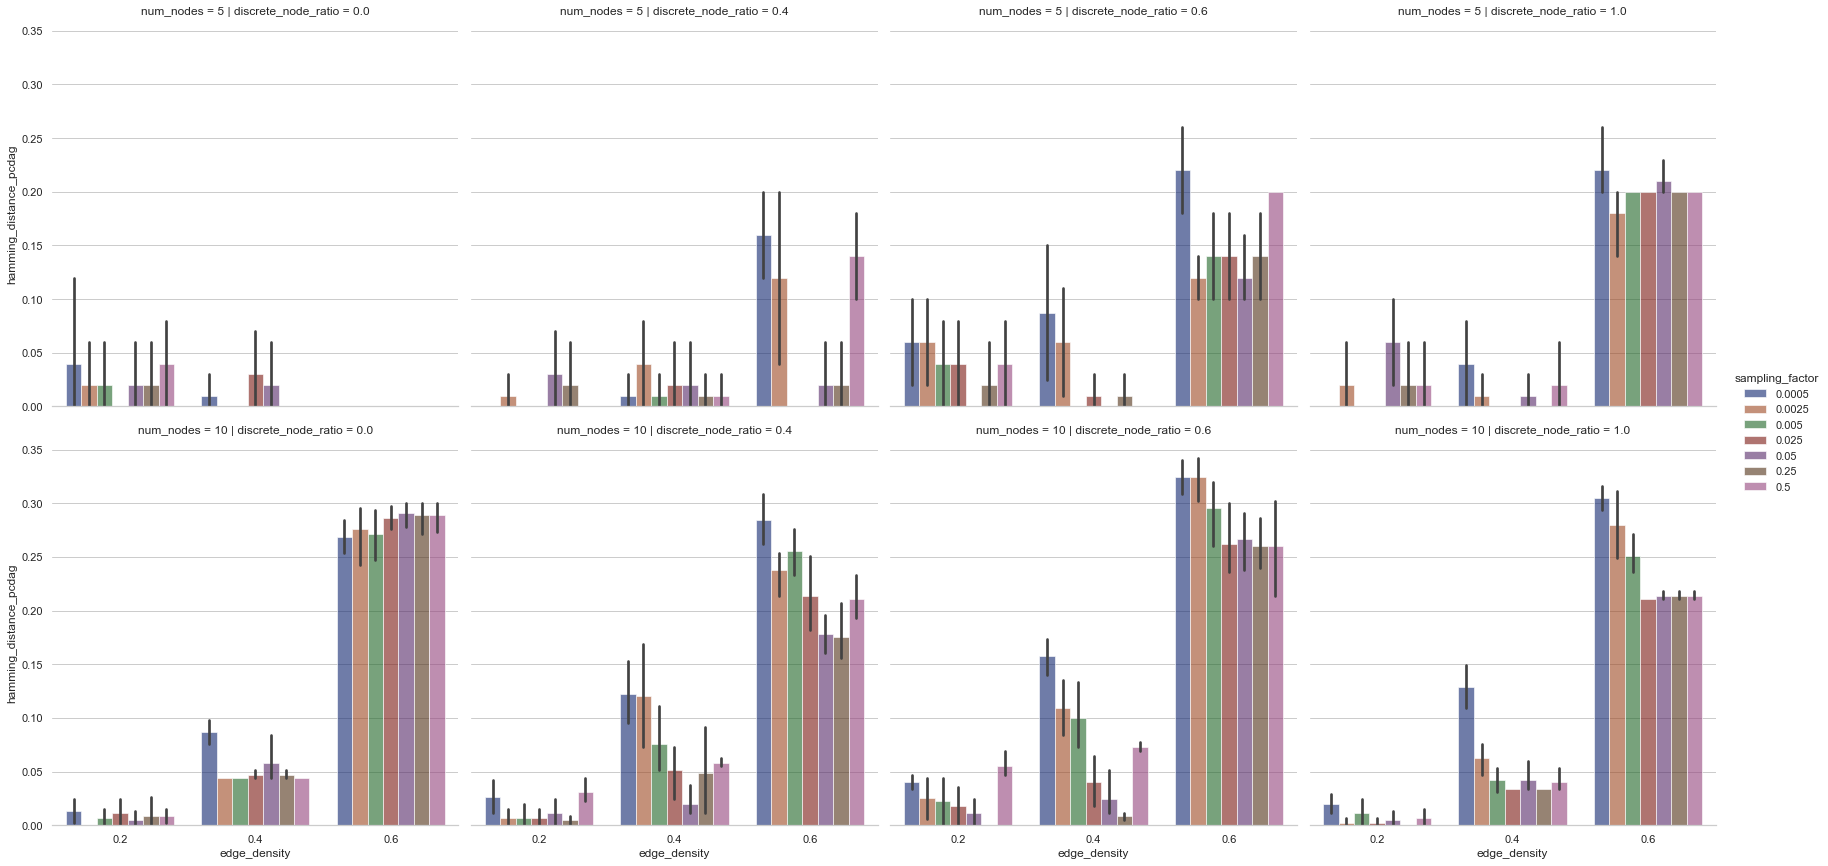

In [11]:
["num_nodes", "edge_density", "num_samples", "alpha", "discrete_node_ratio"]
metrics = ["hamming_distance_pcdag"] #"graph_edit_distance", "mean_jaccard_coefficient"]
plotted_data = cleaned_df[(cleaned_df.alpha == 0.05)]

for metric in metrics:
    
    x="edge_density"
    y=metric
    hue="sampling_factor"
    row="num_nodes"
    col="discrete_node_ratio"
    
    g = sns.catplot(
        data=plotted_data,
        kind="bar",
        x=x,
        y=metric,
        hue=hue,
        row=row,
        col=col,
        palette="dark",
        alpha=.6,
        height=6,
        facet_kws=dict(margin_titles=True),
    )
    #plt.title(f'Metric: {metric}, x={x}, y={y}, hue={hue}, row={row}, col={col}')
    display(g.despine(left=True))

In [12]:
edge_density = 0.6
num_nodes = 5
discrete_node_ratio = 0.4

filtered_df = df[
    (df["config/edge_density"] == edge_density) &
    (df["config/num_nodes"] == num_nodes) &
    (df["config/discrete_node_ratio"] == discrete_node_ratio)
]

network_data = df[["result/job_id",  "result/id", "experiment_config/dataset", "result/meta_results/sampling_factor", "gd_compare/hamming_distance", "config/edge_density", "config/discrete_node_ratio", "config/num_nodes"]]

In [13]:
gt_gml = "./data/gt/ds-5.gml"
est_gml = "./data/result/Graph_169.gml"

gt_graph = nx.read_gml(gt_gml)
est_graph = nx.read_gml(est_gml)

retry_strategy = Retry(
    total=3,
    status_forcelist=[429, 500, 502, 503, 504],
    method_whitelist=["GET", "PUT", "DELETE", "OPTIONS"],
    backoff_factor=10
)
adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount("http://", adapter)

In [17]:
API_HOST = "http://galileo.eaalab.hpi.uni-potsdam.de:5000"
#API_HOST = "http://localhost:5000"
API_RESULT_GRAPH = lambda result_id : f"{API_HOST}/api/result/{result_id}/export?format=GML"
API_GROUND_TRUTH_GRAPH = lambda dataset_id : f"{API_HOST}/api/dataset/{dataset_id}/ground-truth?format=GML"

def get_est_graph(result_id: int, tmp_path="./est_graph.gml"):
    response_graph = http.get(API_RESULT_GRAPH(result_id))

    if response_graph.status_code != 200:
        error_msg = f"API Request to {API_RESULT_GRAPH(result_id)} failed."
        raise Exception(error_msg)

    with open(tmp_path, 'wb') as f:
        f.write(response_graph.content)
        
    return nx.read_gml(tmp_path)

def get_gt_graph(dataset_id: int, tmp_path="./gt-download.gml"):
    response_graph = http.get(API_GROUND_TRUTH_GRAPH(dataset_id))

    if response_graph.status_code != 200:
        error_msg = f"API Request to {API_GROUND_TRUTH_GRAPH(dataset_id)} failed."
        logging.error(error_msg)
        raise Exception(error_msg)
        
    with open(tmp_path, 'wb') as f:
        f.write(response_graph.content)

    return nx.read_gml(tmp_path)

In [19]:
est_graph = get_est_graph(349)
gt_graph = get_gt_graph(1)

ERROR:root:API Request to http://galileo.eaalab.hpi.uni-potsdam.de:5000/api/dataset/1/ground-truth?format=GML failed.


Exception: API Request to http://galileo.eaalab.hpi.uni-potsdam.de:5000/api/dataset/1/ground-truth?format=GML failed.

In [20]:
# GT 
gt_graph = get_gt_graph(1)
nx.draw_spring(gt_graph, with_labels = True)

ERROR:root:API Request to http://galileo.eaalab.hpi.uni-potsdam.de:5000/api/dataset/1/ground-truth?format=GML failed.


Exception: API Request to http://galileo.eaalab.hpi.uni-potsdam.de:5000/api/dataset/1/ground-truth?format=GML failed.

In [ ]:
# EST
nx.draw_spring(est_graph, with_labels = True)

In [ ]:
21 -> 3
22 -> 2
23 -> 1
24 -> 0
25 -> 4

In [ ]:
est_graph.nodes 

interactive(children=(Dropdown(description='edge_density', options=(0.2, 0.4, 0.6), value=0.2), Dropdown(descr…

<function __main__.f(edge_density: float, num_nodes: int, discrete_node_ratio: float, sampling_factor: int)>

/Users/lukas/anaconda3/envs/mpci-backend/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


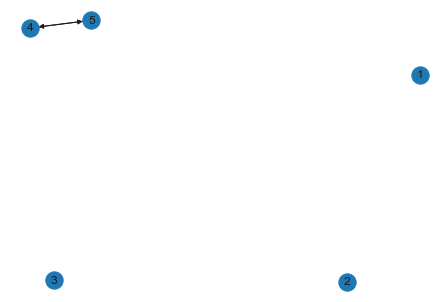

In [34]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def f(edge_density: float,
      num_nodes: int,
      discrete_node_ratio: float,
      sampling_factor: int):
    
    filtered_df = df[
        (df["config/edge_density"] == edge_density) &
        (df["config/num_nodes"] == num_nodes) &
        (df["config/discrete_node_ratio"] == discrete_node_ratio) &
        (df["result/meta_results/sampling_factor"] == sampling_factor)
    ]
    filtered_df = filtered_df[["result/job_id",  "result/id", "experiment_config/dataset", "result/meta_results/sampling_factor", "gd_compare/hamming_distance", "config/edge_density", "config/discrete_node_ratio", "config/num_nodes"]]
    display(filtered_df)
    
    dataset_id = filtered_df.iloc[[0]]["experiment_config/dataset"]
    #gt_graph = get_gt_graph(dataset_id)
    #display(nx.draw_spring(gt_graph, with_labels = True))
    fig = plt.figure(constrained_layout=True)
    spec = gridspec.GridSpec(ncols=1, nrows=len(filtered_df), figure=fig2)
    
    for i, row in filtered_df.iterrows():
        result_id = int(row["result/id"])
        est_graph = get_est_graph(result_id)
        graph = nx.draw_spring(est_graph, with_labels = True)
        sub_fig = fig.add_subplot(graph)
        
    display(fig)

interact(f,
    edge_density=network_data["config/edge_density"].unique(),
    sampling_factor=network_data["result/meta_results/sampling_factor"].unique(),
    num_nodes=network_data["config/num_nodes"].unique(),
    discrete_node_ratio=network_data["config/discrete_node_ratio"].unique(),
)

In [39]:
df[
    (df["config/edge_density"] == edge_density) &
    (df["config/num_nodes"] == num_nodes) &
    (df["config/discrete_node_ratio"] == discrete_node_ratio) &
    (df["result/meta_results/sampling_factor"] == sampling_factor)
]

NameError: name 'sampling_factor' is not defined

/Users/lukas/anaconda3/envs/mpci-backend/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


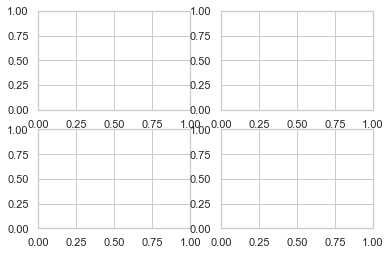

In [38]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig2 = plt.figure(constrained_layout=True)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[1, 0])
f2_ax4 = fig2.add_subplot(spec2[1, 1])